## Predição da Safra de 2020 | SciCrop

<br>

Neste Notebook será utilizado Machine Learning, mais especificamente Classificação* para prever o dano na safra de 2020 baseados nas informações abaixo:

<br><br>

*Foi escolhido a Classificação porque o resultado a ser previsto é categórico (1,2,3) e não quantitativo, como por exemplo, o número de insetos.

<br>

| Variável                 | Descrição                                                    |
| ------------------------ | ------------------------------------------------------------ |
| Identificador_Agricultor | IDENTIFICADOR DO CLIENTE                                     |
| Estimativa_de_Insetos    | Estimativa de insetos por M²                                 |
| Tipo_de_Cultivo          | Classificação do tipo de cultivo (0,1)                       |
| Tipo_de_Solo             | Classificação do tipo de solo (0,1)                          |
| Categoria_Pesticida      | Informação do uso de pesticidas (1- Nunca Usou, 2-Já Usou, 3-Esta usando) |
| Doses_Semana             | Número de doses por semana                                   |
| Semanas_Utilizando       | Número de semanas Utilizada                                  |
| Semanas_Sem_Uso          | Número de semanas sem utilizar                               |
| Temporada                | Temporada Climática (1,2,3)                                  |
| dano_na_plantacao        | Variável de Predição - Dano no Cultivo (0=Sem Danos, 1=Danos causados por outros motivos, 2=Danos gerados pelos pesticidas) |


Este notebook está dividido nas seguintes partes:

<br>
    
    1. Setup do environment
    2. EDA (Exploratory Data Analysis)
    3. Limpando e organizando os dados (caso seja necessário)
    4. Criação do Modelo de Predição
    5. Tunando os Hiperparâmetros
    6. Métricas de Avaliação
    7. Visualizando Category Importance
    8. Visualizando a predição 

### 1. Setup do environment

In [2]:
# Ferramentas básicas
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt

%matplotlib inline

In [ ]:
# Modelos

In [ ]:
# Avalição

In [3]:
# Importando os dados
Safra_18_19 = pd.read_csv('Safra_2018-2019.csv')

# Visualizando a tabela
Safra_18_19.columns

Index(['Unnamed: 0', 'Identificador_Agricultor', 'Estimativa_de_Insetos',
       'Tipo_de_Cultivo', 'Tipo_de_Solo', 'Categoria_Pesticida',
       'Doses_Semana', 'Semanas_Utilizando', 'Semanas_Sem_Uso', 'Temporada',
       'dano_na_plantacao'],
      dtype='object')

### 2. EDA ( Exploratory Data Analysis)

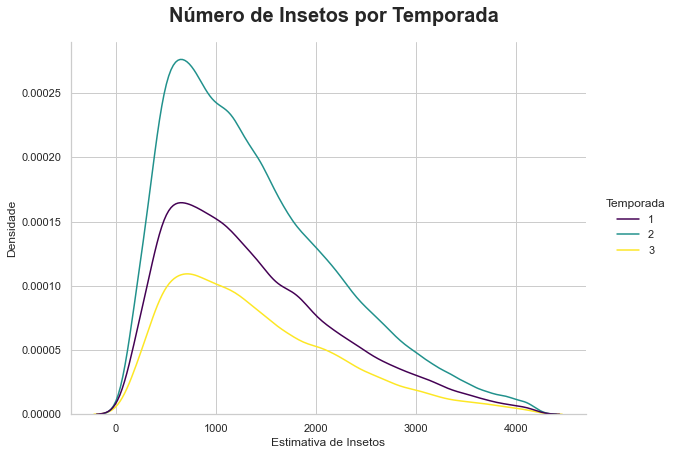

In [64]:
# Visualizando a correlação entre o número de insetos e a estação do ano
sns.set_style('whitegrid')

plot = sns.displot( x        = Safra_18_19.Estimativa_de_Insetos,
                    hue      = Safra_18_19.Temporada, 
                    kind     = 'kde',
                    height   = 6, 
                    aspect   = 11.7/8.27,
                    palette  = 'viridis')

plot.fig.suptitle('Número de Insetos por Temporada',
                   y          = 1.05,
                   fontsize   = 20, 
                   fontweight = 'bold')

plot.set(xlabel = 'Estimativa de Insetos',
         ylabel = 'Densidade')

plt.show()

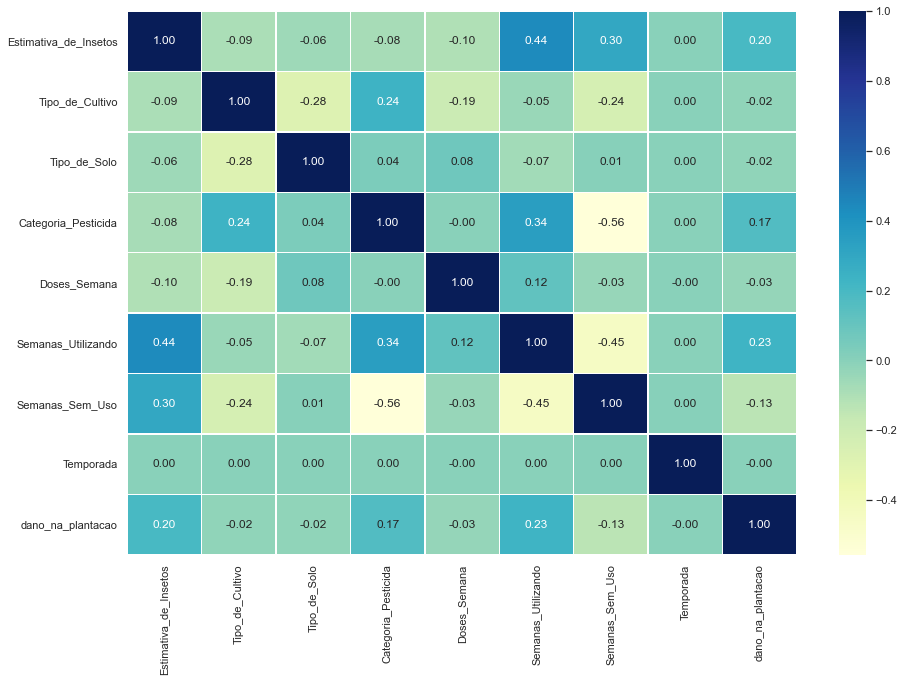

In [96]:
# Visualizando a correlação entre as características de plantio

corr_matrix = Safra_18_19.drop('Unnamed: 0', axis = 1).corr()

fig, ax = plt.subplots(figsize = (15,10))

ax = sns.heatmap(corr_matrix,
                annot      = True,
                linewidths = 0.5,
                fmt        = '.2f',
                cmap       = 'YlGnBu');

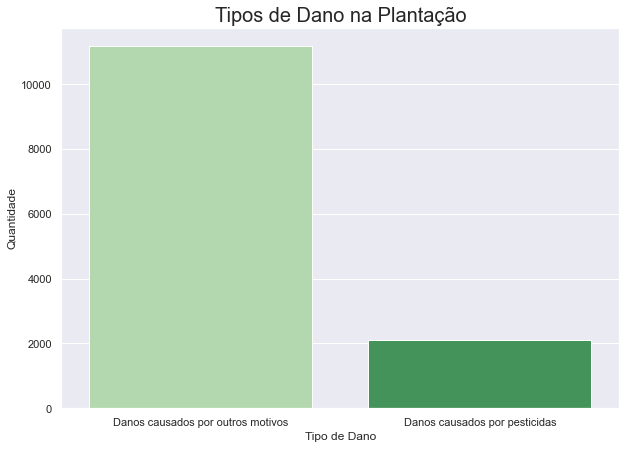

In [105]:
# Visualizando o dano quantitatovamente
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(10,7)})

plot = sns.countplot(palette = 'Greens',
                     x       = Safra_18_19.dano_na_plantacao,
                     order   = [1,2])

plot.set(xlabel = 'Tipo de Dano',
         ylabel = 'Quantidade',
         xticklabels = ['Danos causados por outros motivos', 'Danos causados por pesticidas'])

plt.title('Tipos de Dano na Plantação', size = 20);

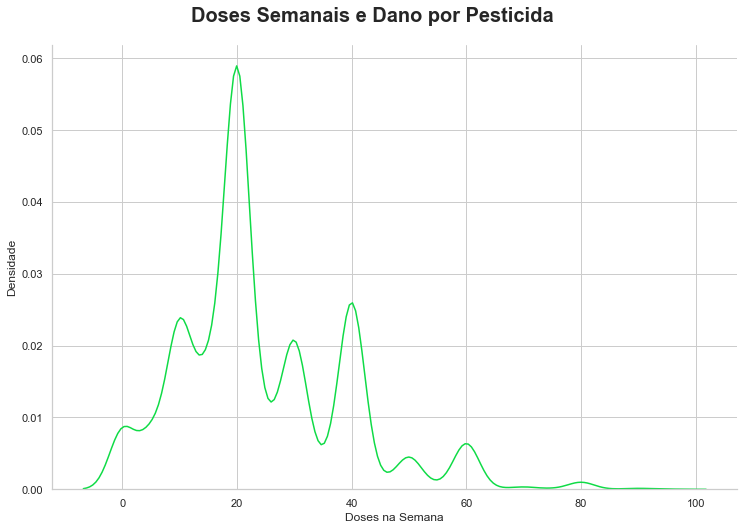

In [160]:
# Visualizando a relação entre Doses por semanas, Dano na Plantação e 
sns.set_style('whitegrid')

plot = sns.displot(Safra_18_19.Doses_Semana[Safra_18_19.dano_na_plantacao == 1], 
                   label  = 'Dano Por Pesticida',
                   color  = '#0fdb46',
                   kind   = 'kde',
                   height = 7,
                   aspect = 1.5)

plot.fig.suptitle('Doses Semanais e Dano por Pesticida',
                   y          = 1.05,
                   fontsize   = 20, 
                   fontweight = 'bold')

plot.set(xlabel = 'Doses na Semana',
         ylabel = 'Densidade')

plt.show()

### 3. Limpando e organizando os dados (caso seja necessário)

<br>

Será julgado que é necessário limpar e organizar caso:

<br>

* O dados não estejam organizados.
* Tenha dado faltando.
* Existam dados categóricos.
* Algum dado esteja no formato errado (ex.: `str`, `int`).

In [20]:
Safra_18_19.isna().sum()

Unnamed: 0                     0
Identificador_Agricultor       0
Estimativa_de_Insetos          0
Tipo_de_Cultivo                0
Tipo_de_Solo                   0
Categoria_Pesticida            0
Doses_Semana                   0
Semanas_Utilizando          8055
Semanas_Sem_Uso                0
Temporada                      0
dano_na_plantacao              0
dtype: int64